# Named Entity Recognition on BC5CDR (Chemical + Disease Corpus) with BioBERT


Notebook to train/fine-tune a BioBERT model to perform named entity recognition (NER). 

The [dataset](https://github.com/aczgh/NER/blob/main/data.txt) used is a pre-processed version of the BC5CDR (BioCreative V CDR task corpus: a resource for  relation extraction) dataset from [Li et al. (2016)](https://github.com/aczgh/NER/blob/main/data.txt).


Our model trained on top of BioBERT has an F1-score of **89.3%** 

The notebook is structured as follows:
* Setting up the GPU Environment
* Getting Data
* Training and Testing the Model
* Using the Model (Running Inference)

#### Task Description

> Named entity recognition (NER) is the task of tagging entities in text with their corresponding type. Approaches typically use BIO notation, which differentiates the beginning (B) and the inside (I) of entities. O is used for non-entity tokens.

# Setting up the GPU Environment

#### Ensure we have a GPU runtime

If you're running this notebook in Google Colab, select `Runtime` > `Change Runtime Type` from the menubar. Ensure that `GPU` is selected as the `Hardware accelerator`. This will allow us to use the GPU to train the model subsequently.

#### Install Dependencies and Restart Runtime

In [1]:
!pip install -q transformers
!pip install -q simpletransformers

     |████████████████████████████████| 3.8 MB 3.8 MB/s 
     |████████████████████████████████| 6.5 MB 31.6 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 895 kB 36.4 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
     |████████████████████████████████| 248 kB 4.0 MB/s 
     |████████████████████████████████| 312 kB 33.9 MB/s 
     |████████████████████████████████| 1.7 MB 45.1 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 9.9 MB 39.7 MB/s 
     |████████████████████████████████| 1.2 MB 42.8 MB/s 
     |████████████████████████████████| 144 kB 43.7 MB/s 
     |████████████████████████████████| 181 kB 61.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 29.9 MB/s 
     |████████████████████████████████| 134 kB 54.1 MB/s 
     |████████████████████████████████| 212 kB 49.3 MB/s 
     |████████████████

You might see the error `ERROR: google-colab X.X.X has requirement ipykernel~=X.X, but you'll have ipykernel X.X.X which is incompatible` after installing the dependencies. **This is normal** and caused by the `simpletransformers` library.

The **solution** to this will be to **reset the execution environment** now. Go to the menu `Runtime` > `Restart runtime` then continue on from the next section to download and process the data.

# Getting Data

#### Pulling the data from Github

The dataset which we pull from the [Github repository](https://github.com/aczgh/NER/blob/main/data.txt).

In [2]:
## import library 
import urllib.request
from pathlib import Path
import pandas as pd

Since the data is formatted in the CoNLL `BIO` type format (you can read more on the tagging format from this [wikipedia article](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))), we need to format it into a `pandas` dataframe with the following function. The 3 important columns in the dataframe are a word token (for mandarin this is a single character), a `BIO` label and a sentence_id to differentiate samples/sentences.

In [3]:
import pandas as pd
def read_conll(filename):
    df = pd.read_csv(filename,
                    sep = '\t', header = None, keep_default_na = False,
                    names = ['words', 'pos', 'chunk', 'labels'],
                    quoting = 3, skip_blank_lines = False)
    df = df[~df['words'].astype(str).str.startswith('-DOCSTART- ')] # Remove the -DOCSTART- header
    df['sentence_id'] = (df.words == '').cumsum()
    return df[df.words != '']

Now we execute the function on the train, test and dev sets we have downloaded from Github. We also `.head()` the training set dataframe for the first 100 rows to check that the words, labels and sentence_id have been split properly.

In [4]:
data = read_conll('/content/data.txt')
data.head(50)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1
5,antihypertensive,ADJ,O,O,1
6,effect,NOUN,O,O,1
7,of,ADP,O,O,1
8,clonidine,NOUN,O,I-Entity,1
9,.,PUNCT,O,O,1
11,In,ADP,O,O,2
12,unanesthetized,ADJ,O,O,2


## check if data which i will train on it has Null value or not 

In [5]:
## check if Null value is Found
data.isnull().sum()

words          0
pos            0
chunk          0
labels         0
sentence_id    0
dtype: int64

## check info of data 


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288498 entries, 2 to 305017
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   words        288498 non-null  object
 1   pos          288498 non-null  object
 2   chunk        288498 non-null  object
 3   labels       288498 non-null  object
 4   sentence_id  288498 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 13.2+ MB


In [7]:
## Describe Data 
data.describe()

,sentence_id
count,288498.000000
mean,7495.932904
std,4321.161932
min,1.000000
25%,3751.000000
50%,7562.000000
75%,11201.000000
max,15022.000000


Text(0.5, 1.0, 'chunck name with count ')

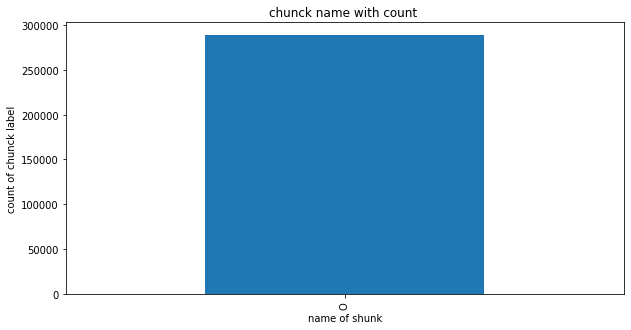

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10,5))
data['chunk'].value_counts().plot(kind='bar')
plt.xlabel("name of shunk")
plt.ylabel("count of chunck label")
plt.title("chunck name with count ")

In [9]:
## print name of column 
data.columns

Index(['words', 'pos', 'chunk', 'labels', 'sentence_id'], dtype='object')

In [10]:
## unique pos
posDistrbuton = pd.DataFrame(data['pos'].value_counts())
posDistrbuton.head(15)

,pos
NOUN,81210
PUNCT,39647
ADP,38302
VERB,33415
ADJ,29196
DET,18410
PROPN,12833
NUM,11651
CCONJ,10081
ADV,7491


Text(0.5, 1.0, 'pos name with count ')

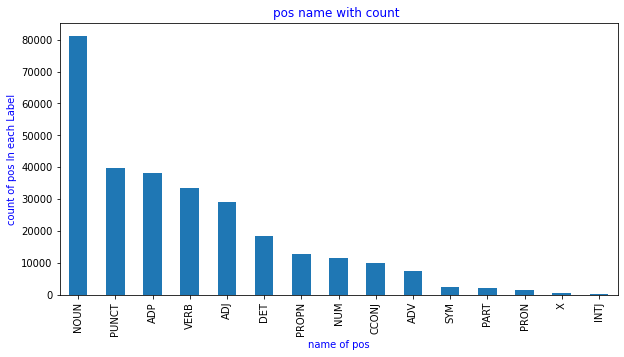

In [11]:
## plot pos tagging distrbution 
import matplotlib.pyplot as plt
plt.figure(figsize= (10,5))
data['pos'].value_counts().plot(kind='bar')
plt.xlabel("name of pos" , color = 'b')
plt.ylabel("count of pos In each Label" ,  color = 'b')
plt.title("pos name with count " , color = 'b')

In [12]:
## unique labels
posDistrbuton = pd.DataFrame(data['labels'].value_counts())
posDistrbuton.head(5)

,labels
O,248543
I-Entity,32979
B-Entity,6976


Text(0.5, 1.0, 'label name with count ')

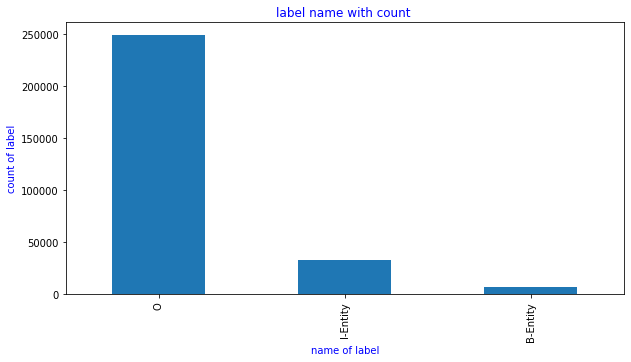

In [13]:
## plot labels tagging distrbution 
import matplotlib.pyplot as plt
plt.figure(figsize= (10,5))
data['labels'].value_counts().plot(kind='bar')
plt.xlabel("name of label" , color = 'b')
plt.ylabel("count of label" ,  color = 'b')
plt.title("label name with count " , color = 'b')

## shuffle data before splitting into Train and Test 

In [14]:
from sklearn.utils import shuffle

In [15]:
data.head(3)

,words,pos,chunk,labels,sentence_id
2,Naloxone,PROPN,O,I-Entity,1
3,reverses,VERB,O,O,1
4,the,DET,O,O,1


In [16]:
len(data['sentence_id'].unique())

12028

In [19]:
## split dataset into Train And Test and validation
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data , test_size=0.05, shuffle = True)
X_test , X_valid = train_test_split(X_test , test_size=0.5, shuffle = True)

In [20]:
print("X_train shape is : " , len(X_train['sentence_id'].unique()) )
print("X_test shape is : " , len(X_test['sentence_id'].unique())  )
print("X_valid shape is : " ,  len(X_valid['sentence_id'].unique()))


X_train shape is :  12028
X_test shape is :  5166
X_valid shape is :  5200


We now print out the statistics (number of sentences) of the train, dev and test sets.

In [21]:
data = [[X_train['sentence_id'].nunique(), X_test['sentence_id'].nunique(), X_valid['sentence_id'].nunique()]]

# Prints out the dataset sizes of train and test sets per label.
pd.DataFrame(data, columns=["Train", "Test", "Dev"])

,Train,Test,Dev
0,12028,5166,5200
